# keras with image MNIST

## pylibs

In [2]:
import os
import cv2
import numpy as np
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.models import load_model
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


## data processing with image

In [3]:
SIF = 0
DDA = 1
#add_color_effect
def add_color_effect(image):
    intensityL1 = 1.2
    intensityL2 = 1.0
    
    new_image = np.zeros_like(image)
    # Resize image to a random size between 27 and 28
    new_size = np.random.randint(26, 28)
    image = zoom(image, (new_size / image.shape[0], new_size / image.shape[1], 1))
    pad_size = (np.random.randint(1, 7), np.random.randint(1, 7))
    # Choose a random side or corner to pad from
    side_or_corner = np.random.choice(['top', 'bottom', 'left', 'right', 'top-left', 'top-right', 'bottom-left', 'bottom-right', 'AD'])

    # Set the padding size based on the chosen side or corner
    if side_or_corner == 'top':
        pad_size = ((pad_size[0], 0), (0, 0), (0, 0))
    elif side_or_corner == 'bottom':
        pad_size = ((0, pad_size[0]), (0, 0), (0, 0))
    elif side_or_corner == 'left':
        pad_size = ((0, 0), (pad_size[1], 0), (0, 0))
    elif side_or_corner == 'right':
        pad_size = ((0, 0), (0, pad_size[1]), (0, 0))
    elif side_or_corner == 'top-left':
        pad_size = ((pad_size[0], 0), (pad_size[1], 0), (0, 0))
    elif side_or_corner == 'top-right':
        pad_size = ((pad_size[0], 0), (0, pad_size[1]), (0, 0))
    elif side_or_corner == 'bottom-left':
        pad_size = ((0, pad_size[0]), (pad_size[1], 0), (0, 0))
    elif side_or_corner == 'bottom-right':
        pad_size = ((0, pad_size[0]), (0, pad_size[1]), (0, 0))
    else: #'AD'
        pad_size = ((pad_size[0], pad_size[0]), (pad_size[1], pad_size[1]), (0, 0))
        
    padded_image = np.pad(image, pad_size, mode='constant')

    new_image = padded_image
    image = new_image
    
    resized_image = cv2.resize(image, (28, 28))
    image = resized_image[:, :, np.newaxis]
    new_image = image
    
    crop_size = np.random.randint(23, 28)
    # Choose a random direction
    direction = np.random.choice(['up', 'down', 'left', 'right'])

    # Set the starting position of the cropped image based on the chosen direction
    if direction == 'up':
        start_x = np.random.randint(0, image.shape[1] - crop_size)
        start_y = 0
    elif direction == 'down':
        start_x = np.random.randint(0, image.shape[1] - crop_size)
        start_y = image.shape[0] - crop_size
    elif direction == 'left':
        start_x = 0
        start_y = np.random.randint(0, image.shape[0] - crop_size)
    else:  # 'right'
        start_x = image.shape[1] - crop_size
        start_y = np.random.randint(0, image.shape[0] - crop_size)

    # Crop the image
    cropped_image = image[start_y:start_y+crop_size, start_x:start_x+crop_size]

    image = cropped_image
    new_image = image
    resized_image = cv2.resize(image, (28, 28))
    image = resized_image[:, :, np.newaxis]
    new_image = image
    for i in range(0, image.shape[0], 4):
        for j in range(0, image.shape[1], 4):
            block = image[i:i+4, j:j+4]
            block = (np.random.rand() * intensityL2 + 1) * block
            new_image[i:i+4, j:j+4] = block
    image = new_image       
    for i in range(0, image.shape[0], 2):
        for j in range(0, image.shape[1], 2):
            block = image[i:i+2, j:j+2]
            block = (np.random.rand() * intensityL1 + 1) * block
            new_image[i:i+2, j:j+2] = block
    return new_image
#save_images_to_dir
def save_images_to_dir(images, labels, dir_path):
    # create the directory if it doesn't exist
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    # iterate over the images and labels
    for i, (image, label) in enumerate(zip(images, labels)):
        # get the class label
        class_label = np.argmax(label)
        # create the file path
        file_path = os.path.join(dir_path, f'image_{i}_class_{class_label}.png')
        # save the image to the file path
        plt.imsave(file_path, image.squeeze(), cmap='gray')

# load dataset
with np.load('mnist.npz') as data:
    x_train, y_train = data['x_train'], data['y_train']
    x_test, y_test = data['x_test'], data['y_test']

# reshape dataset to have a single channel
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# one hot encode target values
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# data processing
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# create a data generator
datagen = ImageDataGenerator(rotation_range=90, horizontal_flip=True, preprocessing_function=lambda x: add_color_effect(1-x))

# prepare an iterators to scale images
train_iterator = datagen.flow(x_train, y_train, batch_size=len(x_train))
test_iterator = datagen.flow(x_test, y_test, batch_size=len(x_test))

# get augmented data
x_train_augmented, y_train_augmented = train_iterator.next()
x_test_augmented, y_test_augmented = test_iterator.next()

# append augmented data to original data
x_train = np.concatenate([x_train, x_train_augmented])
y_train = np.concatenate([y_train, y_train_augmented])
x_test = np.concatenate([x_test, x_test_augmented])
y_test = np.concatenate([y_test, y_test_augmented])

if DDA:
    # prepare an iterators to scale images
    train_iterator = datagen.flow(x_train, y_train, batch_size=len(x_train))
    test_iterator = datagen.flow(x_test, y_test, batch_size=len(x_test))

    # get augmented data
    x_train_augmented, y_train_augmented = train_iterator.next()
    x_test_augmented, y_test_augmented = test_iterator.next()

    # append augmented data to original data
    x_train = np.concatenate([x_train, x_train_augmented])
    y_train = np.concatenate([y_train, y_train_augmented])
    x_test = np.concatenate([x_test, x_test_augmented])
    y_test = np.concatenate([y_test, y_test_augmented])
    
    # prepare an iterators to scale images
    train_iterator = datagen.flow(x_train, y_train, batch_size=len(x_train))
    test_iterator = datagen.flow(x_test, y_test, batch_size=len(x_test))

    # get augmented data
    x_train_augmented, y_train_augmented = train_iterator.next()
    x_test_augmented, y_test_augmented = test_iterator.next()

    # append augmented data to original data
    x_train = np.concatenate([x_train, x_train_augmented])
    y_train = np.concatenate([y_train, y_train_augmented])
    x_test = np.concatenate([x_test, x_test_augmented])
    y_test = np.concatenate([y_test, y_test_augmented])

# save augmented data to directories
if SIF:
    #save_images_to_dir(x_train_augmented, y_train_augmented, 'train')
    save_images_to_dir(x_test_augmented, y_test_augmented, 'test')


## Creating the model

In [15]:
print('Creating a model...\n')

model = Sequential()
model.add(Conv2D(128, (6, 6), activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(256, (4, 4), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(512, (4, 4), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(512, (4, 4), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.1)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.1)))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))
# compile model
opt = SGD(learning_rate=0.05, momentum=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
print('\nThe model was successfully created')


Creating a model...

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 23, 23, 128)       4736      
                                                                 
 batch_normalization_9 (Batc  (None, 23, 23, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 128)      0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 11, 11, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 256)         524544    
                                                                 
 batch_normalization_10 (Bat  (No

## loading the model

In [7]:
try:
    model = load_model('MNIST_model.h5')
except (ImportError, IOError) as e:
    print(f'\033[91mfailed to load the model ERROR:\n{e}')
else:
    print('\033[92m loading model done.')

failed to load the model ERROR:
No file or directory found at MNIST_model.h5


## Training

In [20]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights = True)

print('Training the model...\n')
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test), verbose='auto', callbacks=[early_stopping])
print('Training done.\n')

Training the model...

Epoch 1/100
7500/7500 [==============================] - 69s 9ms/step - loss: 1.3795 - accuracy: 0.7281 - val_loss: 1.1408 - val_accuracy: 0.8087
Epoch 2/100
7500/7500 [==============================] - 68s 9ms/step - loss: 1.3685 - accuracy: 0.7305 - val_loss: 1.1556 - val_accuracy: 0.8065
Epoch 3/100
7500/7500 [==============================] - 69s 9ms/step - loss: 1.3565 - accuracy: 0.7351 - val_loss: 1.1561 - val_accuracy: 0.8061
Epoch 4/100
7500/7500 [==============================] - 70s 9ms/step - loss: 1.3503 - accuracy: 0.7359 - val_loss: 1.1010 - val_accuracy: 0.8129
Epoch 5/100
7500/7500 [==============================] - 69s 9ms/step - loss: 1.3443 - accuracy: 0.7383 - val_loss: 1.1270 - val_accuracy: 0.8126
Epoch 6/100
7500/7500 [==============================] - 70s 9ms/step - loss: 1.3349 - accuracy: 0.7418 - val_loss: 1.1195 - val_accuracy: 0.8152
Epoch 7/100
7500/7500 [==============================] - 70s 9ms/step - loss: 1.3252 - accuracy: 0.74

## Saving model weights

In [29]:
model.save('MNIST_model.h5')

## Analyzing the results

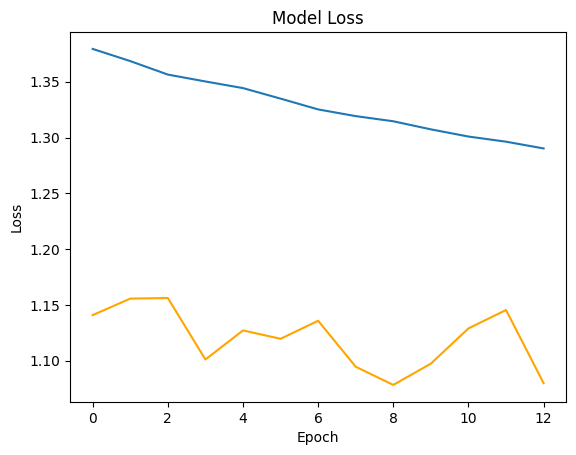

In [21]:
try:
    plt.plot(history.history['loss'], label='loss')
    try:
        plt.plot(history.history['val_loss'], label='val_loss', color='orange')
    except (ValueError, NameError):
        print('\033[91mfailed to load val_loss.')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
except (ValueError, NameError):
    print('\033[91mfailed to load model history.')

loading model done.
1/1 [==============================] - 0s 81ms/step
The predicted digit is 6 with a confidence of 1.00
1/1 [==============================] - 0s 14ms/step
Threshold: 20, Color: white, Predicted digit: 0, Confidence: 0.97
1/1 [==============================] - 0s 13ms/step
Threshold: 20, Color: black, Predicted digit: 6, Confidence: 1.00
1/1 [==============================] - 0s 13ms/step
Threshold: 25, Color: white, Predicted digit: 0, Confidence: 0.95
1/1 [==============================] - 0s 14ms/step
Threshold: 25, Color: black, Predicted digit: 6, Confidence: 1.00
1/1 [==============================] - 0s 13ms/step
Threshold: 30, Color: white, Predicted digit: 0, Confidence: 0.96
1/1 [==============================] - 0s 11ms/step
Threshold: 30, Color: black, Predicted digit: 6, Confidence: 1.00
1/1 [==============================] - 0s 13ms/step
Threshold: 35, Color: white, Predicted digit: 0, Confidence: 0.94
1/1 [==============================] - 0s 13ms/step

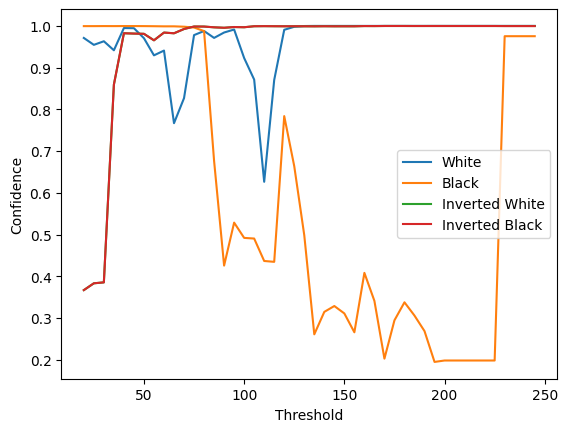

Digit: 0, Percentage: 0.12, Average Confidence: 0.89
Digit: 1, Percentage: 0.17, Average Confidence: 0.99
Digit: 4, Percentage: 0.03, Average Confidence: 0.31
Digit: 6, Percentage: 0.59, Average Confidence: 0.95
Digit: 7, Percentage: 0.02, Average Confidence: 0.37
Digit: 8, Percentage: 0.03, Average Confidence: 0.20
Digit: 9, Percentage: 0.04, Average Confidence: 0.29

The best result is for digit 6 with a score of 1.06


In [28]:
from keras.models import load_model
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import sys

try:
    model = load_model('MNIST_model.h5')
except (ImportError, IOError) as e:
    print(f'failed to load the model ERROR:\n{e}')
    sys.exit()
else:
    print('loading model done.')

# Load and preprocess image
image_dir = input('image dir(.png/.jpg):')
if image_dir == '':
    image_dir = 'image.jpg'
try:
    img = Image.open(image_dir).convert('L')
    if img.format == 'JPEG':
        img = img.convert('RGB')
except FileNotFoundError:
    try:
        img = Image.open(image_dir).convert('L')
        if img.format == 'JPEG':
            img = img.convert('RGB')
    except FileNotFoundError:
        print('cant find: image.(png/jpg)')
        sys.exit()
    
img = img.resize((28, 28))
img_array = np.array(img)
img_array = img_array.reshape(1, 28, 28, 1)

# Make predictions
predictions = model.predict(img_array)
predicted_digit = np.argmax(predictions)
confidence = predictions[0][predicted_digit]
print(f'The predicted digit is {predicted_digit} with a confidence of {confidence:.2f}')

# Create directories if they don't exist
if not os.path.exists('IMG_ITER'):
    os.mkdir('IMG_ITER')
if not os.path.exists('IMG_ITER/white'):
    os.mkdir('IMG_ITER/white')
if not os.path.exists('IMG_ITER/black'):
    os.mkdir('IMG_ITER/black')

# Apply threshold and save images
thresholds = range(20, 250, 5)
white_confidences = []
black_confidences = []
inverted_white_confidences = []
inverted_black_confidences = []
digit_counts = np.zeros(10)
digit_confidences = np.zeros(10)
for threshold in thresholds:
    W_threshold = threshold if threshold <= 195 else 195
    white_thresholded_img = img.point(lambda x: 255 if x < W_threshold else x)
    white_thresholded_img.save(f'IMG_ITER/white/threshold_{W_threshold}.png')
    white_thresholded_img_array = np.array(white_thresholded_img)
    white_thresholded_img_array = white_thresholded_img_array.reshape(1, 28, 28, 1)
    predictions = model.predict(white_thresholded_img_array)
    predicted_digit = np.argmax(predictions)
    confidence = predictions[0][predicted_digit]
    white_confidences.append(confidence)
    digit_counts[predicted_digit] += 1
    digit_confidences[predicted_digit] += confidence
    print(f'Threshold: {W_threshold}, Color: white, Predicted digit: {predicted_digit}, Confidence: {confidence:.2f}')
    
    black_thresholded_img = img.point(lambda x: 0 if x < threshold else x)
    black_thresholded_img.save(f'IMG_ITER/black/threshold_{threshold}.png')
    black_thresholded_img_array = np.array(black_thresholded_img)
    black_thresholded_img_array = black_thresholded_img_array.reshape(1, 28, 28, 1)
    predictions = model.predict(black_thresholded_img_array)
    predicted_digit = np.argmax(predictions)
    confidence = predictions[0][predicted_digit]
    black_confidences.append(confidence)
    digit_counts[predicted_digit] += 1
    digit_confidences[predicted_digit] += confidence
    print(f'Threshold: {threshold}, Color: black, Predicted digit: {predicted_digit}, Confidence: {confidence:.2f}')

    inverted_white_thresholded_img = img.point(lambda x: x if x < W_threshold else 255 - x)
    inverted_white_thresholded_img_array = np.array(inverted_white_thresholded_img)
    inverted_white_thresholded_img_array = inverted_white_thresholded_img_array.reshape(1, 28, 28, 1)
    predictions = model.predict(inverted_white_thresholded_img_array)
    predicted_digit = np.argmax(predictions)
    confidence = predictions[0][predicted_digit]
    inverted_white_confidences.append(confidence)
    digit_counts[predicted_digit] += 1
    digit_confidences[predicted_digit] += confidence

    inverted_black_thresholded_img = img.point(lambda x: x if x < threshold else 255 - x)
    inverted_black_thresholded_img_array = np.array(inverted_black_thresholded_img)
    inverted_black_thresholded_img_array = inverted_black_thresholded_img_array.reshape(1, 28, 28, 1)
    predictions = model.predict(inverted_black_thresholded_img_array)
    predicted_digit = np.argmax(predictions)
    confidence = predictions[0][predicted_digit]
    inverted_black_confidences.append(confidence)
    digit_counts[predicted_digit] += 1
    digit_confidences[predicted_digit] += confidence
# Create graph
plt.plot(thresholds, white_confidences, label='White')
plt.plot(thresholds, black_confidences, label='Black')
plt.plot(thresholds, inverted_white_confidences, label='Inverted White')
plt.plot(thresholds, inverted_black_confidences, label='Inverted Black')
plt.xlabel('Threshold')
plt.ylabel('Confidence')
plt.legend()
plt.show()

# Display most predicted digits and their average confidence
digit_counts = digit_counts / np.sum(digit_counts)
digit_scores = np.zeros(10)
for digit in range(10):
    if digit_counts[digit] > 0:
        avg_confidence = digit_confidences[digit] / ((digit_counts[digit] * len(thresholds) * 2) * 2)
        print(f'Digit: {digit}, Percentage: {digit_counts[digit]:.2f}, Average Confidence: {avg_confidence:.2f}')
        digit_scores[digit] = digit_counts[digit] + (avg_confidence / 3)

best_digit = np.argmax(digit_scores)
best_score = digit_scores[best_digit]
print(f'\nThe best result is for digit {best_digit} with a score of {best_score:.2f}')
